In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import glob

from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
data = glob.glob('/kaggle/input/house-prices-advanced-regression-techniques/*')

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Preprocessing Data

In [3]:
def filter_missing_values_features(train_df, test_df):
    # filter n drop features with distribution od missing values more than half a size of dataset
    # get the dropped_features from test_data and apply it for both data

    thres = int(len(test_df)/2)
    nan_df = test_df.isna().sum().reset_index(name='counts')
    dropped_features = nan_df.query(f'counts >= {thres}')['index'].values

    return train_df.drop(columns=dropped_features), test_df.drop(columns=dropped_features)



def fill_missing_values(train_df, test_df):
    # filter features
    train_df, test_df = filter_missing_values_features(train_df, test_df)

    categorical_feats = train_df.select_dtypes(include=['object', 'bool']).columns
    numerical_feats = train_df.select_dtypes(include=['int', 'float']).columns

    # fill missing value with the mode value for categorical features
    for col in categorical_feats:
        train_mode = train_df[col].mode()[0]
        test_mode = test_df[col].mode()[0]

        train_df[col] = train_df[col].fillna(train_mode)
        test_df[col] = test_df[col].fillna(test_mode)

    # fill missing values with the median value for numerical features
    for col in numerical_feats:
        train_mode = train_df[col].median()
        test_mode = test_df[col].median()

        train_df[col] = train_df[col].fillna(train_mode)
        test_df[col] = test_df[col].fillna(test_mode)

    return train_df, test_df

In [4]:
y_train = train_data['SalePrice']
X_train = train_data.drop(columns=['Id', 'SalePrice'])
X_test = test_data.drop('Id', axis=1)

X_train, X_test = fill_missing_values(X_train, X_test)


# Standardization and Encoding

In [5]:
categorical_feats = X_train.select_dtypes(include=['object', 'bool']).columns.to_list()
numerical_feats = X_train.select_dtypes(include=['int', 'float']).columns.to_list()

def transform_features(train_df, test_df):

    columns = categorical_feats+numerical_feats

    columns_transformer = ColumnTransformer([
        ('encoding', OrdinalEncoder(), categorical_feats),
        ('scaling', StandardScaler(), numerical_feats) ])

    encoded_train = columns_transformer.fit_transform(train_df)
    encoded_test = columns_transformer.transform(test_df)

    return pd.DataFrame(encoded_train, columns=columns), pd.DataFrame(encoded_test, columns=columns)


X_train, X_test = transform_features(X_train, X_test)

# Feature Selection

In [6]:
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

model = LinearRegression()

sfs = SFS(model,
          k_features='best',
         forward=False,
         floating=False,
         scoring='r2',
         cv=5)

sfs.fit(X_train, y_train)


selected_x_train = sfs.transform(X_train)
selected_x_test = sfs.transform(X_test)

pd.DataFrame.from_dict(sfs.get_metric_dict()).T.sort_values(by='avg_score', ascending=False).head()

,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
27,"(3, 7, 10, 11, 13, 14, 16, 19, 20, 21, 28, 29,...","[0.8908777293603438, 0.8187904265882239, 0.847...",0.831482,"(LandContour, Neighborhood, BldgType, HouseSty...",0.056526,0.043979,0.02199
26,"(3, 7, 10, 11, 13, 14, 16, 19, 21, 28, 29, 37,...","[0.8902469717242482, 0.8180007061066266, 0.847...",0.831464,"(LandContour, Neighborhood, BldgType, HouseSty...",0.056233,0.043751,0.021876
25,"(3, 7, 11, 13, 14, 16, 19, 21, 28, 29, 37, 39,...","[0.8905982456058762, 0.8181772731030983, 0.846...",0.831416,"(LandContour, Neighborhood, HouseStyle, RoofMa...",0.05634,0.043835,0.021917
28,"(3, 7, 10, 11, 13, 14, 16, 19, 20, 21, 28, 29,...","[0.890729920800897, 0.8186247492900394, 0.8472...",0.831392,"(LandContour, Neighborhood, BldgType, HouseSty...",0.056522,0.043976,0.021988
24,"(3, 7, 11, 13, 14, 16, 19, 21, 28, 29, 37, 39,...","[0.8908894098446919, 0.8177025045030761, 0.846...",0.831234,"(LandContour, Neighborhood, HouseStyle, RoofMa...",0.056712,0.044124,0.022062


In [7]:
models = {
    'XGBRegressor': XGBRegressor(),
    'GBRegressor': GradientBoostingRegressor()
}

scores = {}

for name, model in models.items():
    score = cross_val_score(model, selected_x_train, y_train, cv=10, scoring='r2')
    scores[name] = score


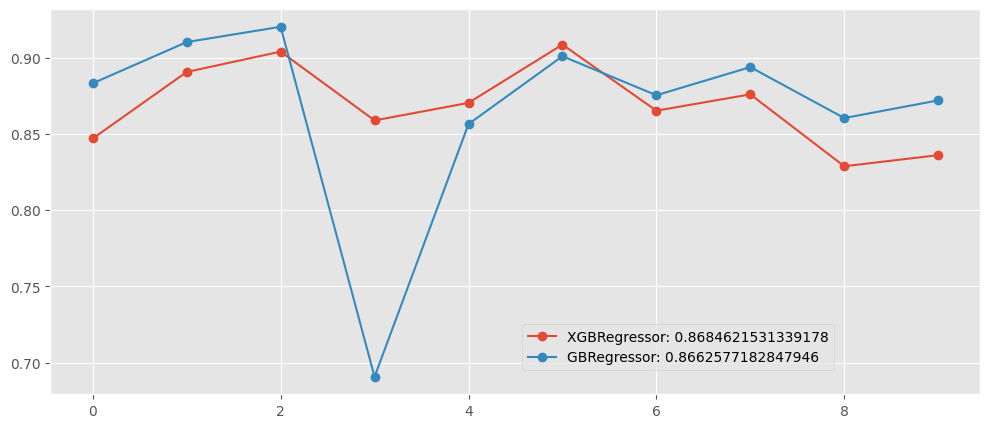

In [8]:
plt.figure(figsize=(12, 5))
for name, score in scores.items():
    plt.plot(np.arange(10), score, 'o-', label=f'{name}: {score.mean()}')

plt.legend(bbox_to_anchor=[.5, .20])
plt.show()

# Hyperparameter Tuning the Model

In [9]:
from sklearn.model_selection import GridSearchCV

model = XGBRegressor(learning_rate=0.1, n_estimators=140, gamma=0, colsample_bytree=0.8)

param_grid = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(selected_x_train, y_train)

cv_result = pd.DataFrame.from_dict(grid_search.cv_results_).sort_values(by='mean_test_score', ascending=False)
cv_result.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_child_weight,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.151265,0.008588,0.004317,0.001400,4,4,"{'max_depth': 4, 'min_child_weight': 4}",0.890951,0.839812,0.879558,0.899644,0.851506,0.872294,0.022961,1
3,0.206353,0.009015,0.004491,0.001244,5,4,"{'max_depth': 5, 'min_child_weight': 4}",0.890123,0.851284,0.883691,0.902679,0.831057,0.871767,0.026501,2
6,0.306499,0.059737,0.004589,0.000896,6,4,"{'max_depth': 6, 'min_child_weight': 4}",0.878923,0.851033,0.890009,0.900303,0.833301,0.870714,0.024909,3
4,0.194210,0.005011,0.003952,0.000174,5,5,"{'max_depth': 5, 'min_child_weight': 5}",0.881488,0.844980,0.884435,0.903721,0.838306,0.870586,0.024925,4
1,0.148405,0.003238,0.003483,0.000060,4,5,"{'max_depth': 4, 'min_child_weight': 5}",0.887599,0.844339,0.880945,0.894908,0.835469,0.868652,0.024049,5


In [10]:
best_estimator = grid_search.best_estimator_

print(f"""
Avg_r2_score: {grid_search.best_score_}
parameters: {grid_search.best_params_}
""")

best_estimator


Avg_r2_score: 0.8722944755543013
parameters: {'max_depth': 4, 'min_child_weight': 4}



XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=4, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=140, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Try the Best Estimator

In [11]:
xtrain, xval, ytrain, yval = train_test_split(selected_x_train, y_train, test_size=0.2, random_state=123)

In [12]:
best_estimator.fit(xtrain, ytrain)
ypred = best_estimator.predict(xval)
RMSLE = np.sqrt(mean_squared_log_error(yval, ypred))

print(f'RMSLE: {RMSLE}')
print(f'r2 Score: {r2_score(yval, ypred)}')

RMSLE: 0.11807210205057152
r2 Score: 0.9066873393288797
